# Task 1: preRT segmentation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from monai.transforms import LoadImage
from monai.data import Dataset, DataLoader, ThreadDataLoader, CacheDataset, decollate_batch
from monai.losses import DiceLoss, DiceCELoss, FocalLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet, SwinUNETR, BasicUNetPlusPlus, SegResNet, resnet152, UNETR
from monai.utils import set_determinism
import os.path
import random
import torch

from monai.transforms import (
    Compose,
    LoadImaged,
    Compose,
    LoadImaged,
    RandSpatialCropd,
    EnsureChannelFirstd,
    ToTensord,
    Resized,
    AsDiscreted,
    RandFlipd,
    CropForegroundd,
    NormalizeIntensityd,
    Spacingd,
    AsDiscrete,
    CenterSpatialCropd
)

/cluster/apps/eb/software/Anaconda3/2022.10/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data_path = "/cluster/projects/vc/data/mic/open/HNTS-MRG/train/"

In [55]:
data_preRT = []
for patient_num in os.listdir(data_path):
    patient = f"{data_path}{patient_num}"
    image = f"{patient}/preRT/{patient_num}_preRT_T2.nii.gz"
    mask = f"{patient}/preRT/{patient_num}_preRT_mask.nii.gz"
    
    data_preRT.append({"image": image, "label": mask})

print(len(data_preRT))

130


In [303]:
set_determinism(seed=1)

training_data = data_preRT[:105]
validation_data = data_preRT[105:]
roi = (256, 256, 48)

train_transforms = Compose(
     [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        CropForegroundd(
                keys=["image", "label"],
                source_key="image",
                k_divisible=[roi[0], roi[1], roi[2]],
                allow_smaller=False
        ),
        RandSpatialCropd(
            keys=["image", "label"],
            roi_size = [roi[0], roi[1], roi[2]],
            random_center = True,
            random_size = False
            ),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        #AsDiscreted(keys=["label"], to_onehot=3),
        ToTensord(keys=["image", "label"])
    ]
)

val_transforms = Compose(
     [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        CenterSpatialCropd(keys=["image", "label"], roi_size=(256, 256, 48)),  # Crop center
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        #AsDiscreted(keys=["label"], to_onehot=3),
        ToTensord(keys=["image", "label"])
    ]
)

In [304]:
train_ds = CacheDataset(data=training_data, transform=train_transforms, cache_rate=1.0)
val_ds = CacheDataset(data=validation_data, transform=val_transforms, cache_rate=1.0)

Loading dataset: 100%|██████████| 25/25 [00:14<00:00,  1.69it/s]


In [305]:
train_dataloader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_ds, batch_size=4, shuffle=False, num_workers=0)

In [306]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = None

In [334]:
#Run this cell for UNet
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=3,
    channels=(16,32,64,128,256),
    strides=(2, 2, 2, 2),
).to(device)

model_name = "U-Net"

In [58]:
model = SwinUNETR(
    img_size = roi,
    in_channels=1,
    out_channels=3,
).to(device)

model_name = "Swin-UNet"

In [ ]:
model = BasicUNetPlusPlus(
    spatial_dims=3,
    in_channels=1,
    out_channels=3,
)

model_name = "Basic U-Net++"

In [332]:
model = SegResNet(
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16,
    in_channels=1,
    out_channels=3,
    dropout_prob=0.2,
).to(device)

model_name = "SegResNet"

In [318]:
from collections import Counter

class_counts = Counter()

for idx in range(len(train_ds)):
    label = train_ds[idx]["label"]

    if label.ndim > 1 and label.shape[0] > 1:  
        label = np.argmax(label, axis=0)
    unique_values, counts = np.unique(label, return_counts=True)
    class_counts.update(dict(zip(unique_values, counts)))

class_counts = np.array([class_counts.get(cls, 0) for cls in range(3)])
class_counts = class_counts / class_counts.min()
print(f"Class counts: {class_counts}")


Class counts: [313.72273618   1.           1.08019141]


In [319]:
beta = 0.99
effective_num = (1 - np.power(beta, class_counts)) / (1 - beta)

class_weights = 1.0 / effective_num

class_weights = class_weights / np.sum(class_weights)

class_weights_tensor = torch.tensor(class_weights).float().to(device)
print(class_weights_tensor)

tensor([0.0054, 0.5164, 0.4782], device='cuda:0')


In [323]:
# Step 2: Load the state dictionary
state_dict = torch.load("model_weights.pth")

# Step 3: Load the weights into the model
model.load_state_dict(state_dict)

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


<All keys matched successfully>

In [336]:
import gc
from monai.inferers import sliding_window_inference
from tqdm import tqdm
from collections import defaultdict
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters())
#loss_function = FocalLoss(include_background=True, to_onehot_y=True, weight=class_weights_tensor)
#optimizer = torch.optim.Adam(model.parameters())
#adamW
dice_metric = DiceMetric(include_background=True, reduction="mean")
max_epochs = 200
post_label = AsDiscrete(to_onehot=3)
post_pred = AsDiscrete(argmax=True, to_onehot=3)

print(f"Training: {model_name}")

training_loss_pr_epoch = []
validation_loss_pr_epoch = []
dice_metric_pr_epoch = []

for epoch in range(max_epochs):
        
        torch.cuda.empty_cache()
        gc.collect()

        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        training_losses = []
        unique_labels_dict = defaultdict(int)
        
        for batch_data in tqdm(train_dataloader):
            images, labels = batch_data["image"].to(device), batch_data["label"].to(device)
            optimizer.zero_grad()
            outputs = model(images)
            
            val_labels_list = decollate_batch(labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            
            
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            training_losses.append(loss.item())
            
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
        training_dice = dice_metric.aggregate().item()
        dice_metric.reset()

        validation_losses = []
        model.eval()
        unique_labels_dict_val = defaultdict(int)
        with torch.no_grad():
            dice_scores = []
            for batch in tqdm(val_dataloader):
                images, labels = batch["image"].to(device), batch["label"].to(device)
                
                outputs = model(images)
                
                # Calculate loss
                loss = loss_function(outputs, labels)
                validation_losses.append(loss.item())
                
                #segmentation guide
                val_labels_list = decollate_batch(labels)
                val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
                val_outputs_list = decollate_batch(outputs)
                val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
                
                dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            validation_dice = dice_metric.aggregate().item()
            dice_metric.reset()
            dice_metric_pr_epoch.append(validation_dice)


        training_loss_pr_epoch.append(np.mean(training_losses))
        validation_loss_pr_epoch.append(np.mean(validation_losses))
        print(f"Training mean loss: {np.mean(training_losses)}")
        print(f"Validation mean loss: {np.mean(validation_losses)}")
        print(f"Training dice {training_dice}")
        print(f"Validation Mean Dice: {validation_dice}")

Training: U-Net
----------
epoch 1/200


100%|██████████| 7/7 [00:00<00:00, 23.31it/s]


Training mean loss: 0.6552641855345832
Validation mean loss: 0.6667682102748326
Training dice 0.5802717208862305
Validation Mean Dice: 0.41957420110702515
----------
epoch 2/200


100%|██████████| 7/7 [00:00<00:00, 23.38it/s]


Training mean loss: 0.6543259311605383
Validation mean loss: 0.6560918603624616
Training dice 0.5404253005981445
Validation Mean Dice: 0.44157350063323975
----------
epoch 3/200


100%|██████████| 7/7 [00:00<00:00, 22.98it/s]


Training mean loss: 0.6512604819403754
Validation mean loss: 0.6341768162591117
Training dice 0.5555133819580078
Validation Mean Dice: 0.4554598331451416
----------
epoch 4/200


100%|██████████| 7/7 [00:00<00:00, 21.36it/s]


Training mean loss: 0.6488149740077831
Validation mean loss: 0.64042181628091
Training dice 0.5825062990188599
Validation Mean Dice: 0.4616153836250305
----------
epoch 5/200


100%|██████████| 7/7 [00:00<00:00, 23.55it/s]


Training mean loss: 0.6499881700233177
Validation mean loss: 0.6619339415005275
Training dice 0.5685465335845947
Validation Mean Dice: 0.4470454752445221
----------
epoch 6/200


100%|██████████| 7/7 [00:00<00:00, 23.32it/s]


Training mean loss: 0.6443770064247979
Validation mean loss: 0.6395662001201085
Training dice 0.5839871168136597
Validation Mean Dice: 0.4657704830169678
----------
epoch 7/200


100%|██████████| 7/7 [00:00<00:00, 23.54it/s]


Training mean loss: 0.6477241096673189
Validation mean loss: 0.6343477623803275
Training dice 0.5794012546539307
Validation Mean Dice: 0.4825984835624695
----------
epoch 8/200


100%|██████████| 7/7 [00:00<00:00, 23.31it/s]


Training mean loss: 0.6426290560651708
Validation mean loss: 0.6236294422830854
Training dice 0.5782962441444397
Validation Mean Dice: 0.49128884077072144
----------
epoch 9/200


100%|██████████| 7/7 [00:00<00:00, 22.33it/s]


Training mean loss: 0.644663049115075
Validation mean loss: 0.6260124530111041
Training dice 0.5670012831687927
Validation Mean Dice: 0.475260466337204
----------
epoch 10/200


100%|██████████| 7/7 [00:00<00:00, 22.85it/s]


Training mean loss: 0.6327266295750936
Validation mean loss: 0.6215103779520307
Training dice 0.5807393193244934
Validation Mean Dice: 0.47742506861686707
----------
epoch 11/200


100%|██████████| 7/7 [00:00<00:00, 23.58it/s]


Training mean loss: 0.6367984414100647
Validation mean loss: 0.6407280053411212
Training dice 0.6498540043830872
Validation Mean Dice: 0.4483844041824341
----------
epoch 12/200


100%|██████████| 7/7 [00:00<00:00, 23.10it/s]


Training mean loss: 0.6368517544534471
Validation mean loss: 0.6142411657742092
Training dice 0.578000545501709
Validation Mean Dice: 0.4850841760635376
----------
epoch 13/200


100%|██████████| 7/7 [00:00<00:00, 22.79it/s]


Training mean loss: 0.6373047497537401
Validation mean loss: 0.6321927905082703
Training dice 0.6165788173675537
Validation Mean Dice: 0.46714428067207336
----------
epoch 14/200


100%|██████████| 7/7 [00:00<00:00, 22.17it/s]


Training mean loss: 0.6255065136485629
Validation mean loss: 0.6214113746370588
Training dice 0.5963036417961121
Validation Mean Dice: 0.47655487060546875
----------
epoch 15/200


100%|██████████| 7/7 [00:00<00:00, 23.50it/s]


Training mean loss: 0.6350804456958065
Validation mean loss: 0.637258265699659
Training dice 0.5999184846878052
Validation Mean Dice: 0.4579639434814453
----------
epoch 16/200


100%|██████████| 7/7 [00:00<00:00, 23.38it/s]


Training mean loss: 0.6378631967085379
Validation mean loss: 0.6249035767146519
Training dice 0.6303749680519104
Validation Mean Dice: 0.4810132682323456
----------
epoch 17/200


100%|██████████| 7/7 [00:00<00:00, 23.40it/s]


Training mean loss: 0.6369661799183598
Validation mean loss: 0.6222753695079258
Training dice 0.5789979100227356
Validation Mean Dice: 0.48617589473724365
----------
epoch 18/200


100%|██████████| 7/7 [00:00<00:00, 23.07it/s]


Training mean loss: 0.6249740344506723
Validation mean loss: 0.6266389744622367
Training dice 0.6252251267433167
Validation Mean Dice: 0.4899592101573944
----------
epoch 19/200


100%|██████████| 7/7 [00:00<00:00, 22.21it/s]


Training mean loss: 0.6316496862305535
Validation mean loss: 0.6255734477724347
Training dice 0.5944312810897827
Validation Mean Dice: 0.4895445704460144
----------
epoch 20/200


100%|██████████| 7/7 [00:00<00:00, 22.71it/s]


Training mean loss: 0.6212594089684663
Validation mean loss: 0.6227245926856995
Training dice 0.5832247138023376
Validation Mean Dice: 0.5007661581039429
----------
epoch 21/200


100%|██████████| 7/7 [00:00<00:00, 23.24it/s]


Training mean loss: 0.6334098290514063
Validation mean loss: 0.6410159298351833
Training dice 0.609619140625
Validation Mean Dice: 0.46880972385406494
----------
epoch 22/200


100%|██████████| 7/7 [00:00<00:00, 23.45it/s]


Training mean loss: 0.6121583007000111
Validation mean loss: 0.6273668323244367
Training dice 0.5994025468826294
Validation Mean Dice: 0.5003316402435303
----------
epoch 23/200


100%|██████████| 7/7 [00:00<00:00, 23.19it/s]


Training mean loss: 0.6140230761633979
Validation mean loss: 0.6212787202426365
Training dice 0.6332517862319946
Validation Mean Dice: 0.504983127117157
----------
epoch 24/200


100%|██████████| 7/7 [00:00<00:00, 22.20it/s]


Training mean loss: 0.6230982387507403
Validation mean loss: 0.5997858898980277
Training dice 0.5934427380561829
Validation Mean Dice: 0.5528827905654907
----------
epoch 25/200


100%|██████████| 7/7 [00:00<00:00, 22.69it/s]


Training mean loss: 0.6131472653812833
Validation mean loss: 0.5917826294898987
Training dice 0.6231845021247864
Validation Mean Dice: 0.5403693318367004
----------
epoch 26/200


100%|██████████| 7/7 [00:00<00:00, 23.07it/s]


Training mean loss: 0.6140884889496697
Validation mean loss: 0.5901662196431842
Training dice 0.6260249614715576
Validation Mean Dice: 0.5584099292755127
----------
epoch 27/200


100%|██████████| 7/7 [00:00<00:00, 23.20it/s]


Training mean loss: 0.600336456740344
Validation mean loss: 0.5770478802067893
Training dice 0.622812032699585
Validation Mean Dice: 0.5567989349365234
----------
epoch 28/200


100%|██████████| 7/7 [00:00<00:00, 22.34it/s]


Training mean loss: 0.5889603109271438
Validation mean loss: 0.6002573796680996
Training dice 0.6163556575775146
Validation Mean Dice: 0.5505987405776978
----------
epoch 29/200


100%|██████████| 7/7 [00:00<00:00, 22.19it/s]


Training mean loss: 0.6025319673396923
Validation mean loss: 0.5876425547259194
Training dice 0.6583932638168335
Validation Mean Dice: 0.5341206192970276
----------
epoch 30/200


100%|██████████| 7/7 [00:00<00:00, 22.21it/s]


Training mean loss: 0.5959649549590217
Validation mean loss: 0.5618257863180978
Training dice 0.6477174162864685
Validation Mean Dice: 0.5894355177879333
----------
epoch 31/200


100%|██████████| 7/7 [00:00<00:00, 23.20it/s]


Training mean loss: 0.595994563014419
Validation mean loss: 0.5866916605404445
Training dice 0.6492290496826172
Validation Mean Dice: 0.563361644744873
----------
epoch 32/200


100%|██████████| 7/7 [00:00<00:00, 23.90it/s]


Training mean loss: 0.5798848988833251
Validation mean loss: 0.52702796459198
Training dice 0.6514710187911987
Validation Mean Dice: 0.6093305349349976
----------
epoch 33/200


100%|██████████| 7/7 [00:00<00:00, 23.58it/s]


Training mean loss: 0.5874984242297985
Validation mean loss: 0.5498560070991516
Training dice 0.6672083735466003
Validation Mean Dice: 0.5847256183624268
----------
epoch 34/200


100%|██████████| 7/7 [00:00<00:00, 22.81it/s]


Training mean loss: 0.5815819490838934
Validation mean loss: 0.5892935906137738
Training dice 0.6316700577735901
Validation Mean Dice: 0.5670261979103088
----------
epoch 35/200


100%|██████████| 7/7 [00:00<00:00, 23.70it/s]


Training mean loss: 0.6024103021180188
Validation mean loss: 0.5452077729361398
Training dice 0.6589503884315491
Validation Mean Dice: 0.5990418195724487
----------
epoch 36/200


100%|██████████| 7/7 [00:00<00:00, 23.15it/s]


Training mean loss: 0.5900479179841501
Validation mean loss: 0.5377027818134853
Training dice 0.700151264667511
Validation Mean Dice: 0.6020991802215576
----------
epoch 37/200


100%|██████████| 7/7 [00:00<00:00, 23.58it/s]


Training mean loss: 0.5794103498812075
Validation mean loss: 0.5415958123547691
Training dice 0.6682842373847961
Validation Mean Dice: 0.595536470413208
----------
epoch 38/200


100%|██████████| 7/7 [00:00<00:00, 23.81it/s]


Training mean loss: 0.5955046536745848
Validation mean loss: 0.5463530761854989
Training dice 0.6485751867294312
Validation Mean Dice: 0.6084816455841064
----------
epoch 39/200


100%|██████████| 7/7 [00:00<00:00, 22.58it/s]


Training mean loss: 0.5773583198035205
Validation mean loss: 0.5439398884773254
Training dice 0.6759105324745178
Validation Mean Dice: 0.5901785492897034
----------
epoch 40/200


100%|██████████| 7/7 [00:00<00:00, 22.88it/s]


Training mean loss: 0.5624299292211179
Validation mean loss: 0.5234040745667049
Training dice 0.6852149367332458
Validation Mean Dice: 0.6200075745582581
----------
epoch 41/200


100%|██████████| 7/7 [00:00<00:00, 23.74it/s]


Training mean loss: 0.57375000472422
Validation mean loss: 0.5542800171034676
Training dice 0.6726184487342834
Validation Mean Dice: 0.5936114192008972
----------
epoch 42/200


100%|██████████| 7/7 [00:00<00:00, 23.74it/s]


Training mean loss: 0.5771574631885246
Validation mean loss: 0.5739213824272156
Training dice 0.7049309611320496
Validation Mean Dice: 0.5822560787200928
----------
epoch 43/200


100%|██████████| 7/7 [00:00<00:00, 23.41it/s]


Training mean loss: 0.590812008689951
Validation mean loss: 0.5640394347054618
Training dice 0.6962032318115234
Validation Mean Dice: 0.5832506418228149
----------
epoch 44/200


100%|██████████| 7/7 [00:00<00:00, 22.83it/s]


Training mean loss: 0.5718349085913764
Validation mean loss: 0.5474548850740705
Training dice 0.6678947806358337
Validation Mean Dice: 0.5795304179191589
----------
epoch 45/200


100%|██████████| 7/7 [00:00<00:00, 23.65it/s]


Training mean loss: 0.5637962144834024
Validation mean loss: 0.558422429221017
Training dice 0.6459794044494629
Validation Mean Dice: 0.5906752943992615
----------
epoch 46/200


100%|██████████| 7/7 [00:00<00:00, 23.96it/s]


Training mean loss: 0.5718573398060269
Validation mean loss: 0.5282903569085258
Training dice 0.6653376817703247
Validation Mean Dice: 0.6185351014137268
----------
epoch 47/200


100%|██████████| 7/7 [00:00<00:00, 23.56it/s]


Training mean loss: 0.567040870587031
Validation mean loss: 0.541660589831216
Training dice 0.6925932168960571
Validation Mean Dice: 0.5949035882949829
----------
epoch 48/200


100%|██████████| 7/7 [00:00<00:00, 22.72it/s]


Training mean loss: 0.5781933058191229
Validation mean loss: 0.5092590536390033
Training dice 0.6643925309181213
Validation Mean Dice: 0.6387509703636169
----------
epoch 49/200


100%|██████████| 7/7 [00:00<00:00, 22.68it/s]


Training mean loss: 0.5879603149714293
Validation mean loss: 0.4924848803452083
Training dice 0.6756519675254822
Validation Mean Dice: 0.6504075527191162
----------
epoch 50/200


100%|██████████| 7/7 [00:00<00:00, 24.07it/s]


Training mean loss: 0.556975574405105
Validation mean loss: 0.4895046523639134
Training dice 0.6870255470275879
Validation Mean Dice: 0.6538461446762085
----------
epoch 51/200


100%|██████████| 7/7 [00:00<00:00, 23.64it/s]


Training mean loss: 0.5648555358250936
Validation mean loss: 0.5037926988942283
Training dice 0.6911182403564453
Validation Mean Dice: 0.6344683170318604
----------
epoch 52/200


100%|██████████| 7/7 [00:00<00:00, 23.53it/s]


Training mean loss: 0.5594095598768305
Validation mean loss: 0.5175031764166695
Training dice 0.7004128694534302
Validation Mean Dice: 0.6244062185287476
----------
epoch 53/200


100%|██████████| 7/7 [00:00<00:00, 23.38it/s]


Training mean loss: 0.5654726613450933
Validation mean loss: 0.5393420159816742
Training dice 0.6965430974960327
Validation Mean Dice: 0.6049714684486389
----------
epoch 54/200


100%|██████████| 7/7 [00:00<00:00, 22.93it/s]


Training mean loss: 0.5489347367374985
Validation mean loss: 0.5086394335542407
Training dice 0.6957981586456299
Validation Mean Dice: 0.6405842304229736
----------
epoch 55/200


100%|██████████| 7/7 [00:00<00:00, 23.65it/s]


Training mean loss: 0.5538372695446014
Validation mean loss: 0.5116818078926632
Training dice 0.6651385426521301
Validation Mean Dice: 0.6391593217849731
----------
epoch 56/200


100%|██████████| 7/7 [00:00<00:00, 23.44it/s]


Training mean loss: 0.5831670959790548
Validation mean loss: 0.5312544618334089
Training dice 0.6595938801765442
Validation Mean Dice: 0.6178662180900574
----------
epoch 57/200


100%|██████████| 7/7 [00:00<00:00, 23.45it/s]


Training mean loss: 0.578270994954639
Validation mean loss: 0.48874356491225107
Training dice 0.6691612601280212
Validation Mean Dice: 0.6491329073905945
----------
epoch 58/200


100%|██████████| 7/7 [00:00<00:00, 23.55it/s]


Training mean loss: 0.5441119141048856
Validation mean loss: 0.5364756115845272
Training dice 0.7071746587753296
Validation Mean Dice: 0.6055343151092529
----------
epoch 59/200


100%|██████████| 7/7 [00:00<00:00, 23.01it/s]


Training mean loss: 0.564509720714004
Validation mean loss: 0.49150839873722624
Training dice 0.6598860025405884
Validation Mean Dice: 0.646079957485199
----------
epoch 60/200


100%|██████████| 7/7 [00:00<00:00, 23.11it/s]


Training mean loss: 0.56888633635309
Validation mean loss: 0.5058833232947758
Training dice 0.6881667375564575
Validation Mean Dice: 0.6379817724227905
----------
epoch 61/200


100%|██████████| 7/7 [00:00<00:00, 22.98it/s]


Training mean loss: 0.5535604644704748
Validation mean loss: 0.5075017469269889
Training dice 0.6744057536125183
Validation Mean Dice: 0.6336244940757751
----------
epoch 62/200


100%|██████████| 7/7 [00:00<00:00, 23.76it/s]


Training mean loss: 0.5499292556886319
Validation mean loss: 0.5160130602972848
Training dice 0.6917634010314941
Validation Mean Dice: 0.6288689374923706
----------
epoch 63/200


100%|██████████| 7/7 [00:00<00:00, 23.52it/s]


Training mean loss: 0.560710429041474
Validation mean loss: 0.4914718781198774
Training dice 0.6940566301345825
Validation Mean Dice: 0.6539089679718018
----------
epoch 64/200


100%|██████████| 7/7 [00:00<00:00, 22.77it/s]


Training mean loss: 0.5604579404548362
Validation mean loss: 0.4915835091045925
Training dice 0.6991218328475952
Validation Mean Dice: 0.6460503935813904
----------
epoch 65/200


100%|██████████| 7/7 [00:00<00:00, 23.38it/s]


Training mean loss: 0.5649963661476418
Validation mean loss: 0.4927883744239807
Training dice 0.7046414613723755
Validation Mean Dice: 0.642620325088501
----------
epoch 66/200


100%|██████████| 7/7 [00:00<00:00, 23.15it/s]


Training mean loss: 0.5594133657437784
Validation mean loss: 0.47737921135766165
Training dice 0.6885610222816467
Validation Mean Dice: 0.6588261127471924
----------
epoch 67/200


100%|██████████| 7/7 [00:00<00:00, 23.44it/s]


Training mean loss: 0.5467555931320897
Validation mean loss: 0.5258683221680778
Training dice 0.6915790438652039
Validation Mean Dice: 0.6161783337593079
----------
epoch 68/200


100%|██████████| 7/7 [00:00<00:00, 23.27it/s]


Training mean loss: 0.5388316302387802
Validation mean loss: 0.5026939596448626
Training dice 0.6886128187179565
Validation Mean Dice: 0.62993323802948
----------
epoch 69/200


100%|██████████| 7/7 [00:00<00:00, 21.90it/s]


Training mean loss: 0.5214926468001472
Validation mean loss: 0.4829861947468349
Training dice 0.7261622548103333
Validation Mean Dice: 0.6571332812309265
----------
epoch 70/200


100%|██████████| 7/7 [00:00<00:00, 22.76it/s]


Training mean loss: 0.5321844209123541
Validation mean loss: 0.5106716794627053
Training dice 0.6817294359207153
Validation Mean Dice: 0.6364243030548096
----------
epoch 71/200


100%|██████████| 7/7 [00:00<00:00, 23.12it/s]


Training mean loss: 0.5512070412989016
Validation mean loss: 0.48456415959766935
Training dice 0.6926594972610474
Validation Mean Dice: 0.6584173440933228
----------
epoch 72/200


100%|██████████| 7/7 [00:00<00:00, 22.40it/s]


Training mean loss: 0.5603731252529003
Validation mean loss: 0.5085887440613338
Training dice 0.7257624268531799
Validation Mean Dice: 0.6278162598609924
----------
epoch 73/200


100%|██████████| 7/7 [00:00<00:00, 22.24it/s]


Training mean loss: 0.5290262544596637
Validation mean loss: 0.4877471455505916
Training dice 0.7057832479476929
Validation Mean Dice: 0.6509271264076233
----------
epoch 74/200


100%|██████████| 7/7 [00:00<00:00, 21.48it/s]


Training mean loss: 0.5266313243795324
Validation mean loss: 0.49620660287993296
Training dice 0.7084438800811768
Validation Mean Dice: 0.6419979929924011
----------
epoch 75/200


100%|██████████| 7/7 [00:00<00:00, 22.30it/s]


Training mean loss: 0.5418341568222752
Validation mean loss: 0.4824598218713488
Training dice 0.7006062865257263
Validation Mean Dice: 0.6529135704040527
----------
epoch 76/200


100%|██████████| 7/7 [00:00<00:00, 23.28it/s]


Training mean loss: 0.5644624078715289
Validation mean loss: 0.5160878939288003
Training dice 0.7044773697853088
Validation Mean Dice: 0.6269370317459106
----------
epoch 77/200


100%|██████████| 7/7 [00:00<00:00, 22.28it/s]


Training mean loss: 0.5285564340926983
Validation mean loss: 0.4914604553154537
Training dice 0.6813018918037415
Validation Mean Dice: 0.6519535779953003
----------
epoch 78/200


100%|██████████| 7/7 [00:00<00:00, 22.67it/s]


Training mean loss: 0.5279767292517202
Validation mean loss: 0.4999952273709433
Training dice 0.6897281408309937
Validation Mean Dice: 0.6455620527267456
----------
epoch 79/200


100%|██████████| 7/7 [00:00<00:00, 22.11it/s]


Training mean loss: 0.54489576154285
Validation mean loss: 0.4754269633974348
Training dice 0.7073971033096313
Validation Mean Dice: 0.662209153175354
----------
epoch 80/200


100%|██████████| 7/7 [00:00<00:00, 22.83it/s]


Training mean loss: 0.5542663655899189
Validation mean loss: 0.48122973101479666
Training dice 0.6917731761932373
Validation Mean Dice: 0.6601017713546753
----------
epoch 81/200


100%|██████████| 7/7 [00:00<00:00, 23.42it/s]


Training mean loss: 0.5523742106225755
Validation mean loss: 0.45508659737450735
Training dice 0.6854060292243958
Validation Mean Dice: 0.6854231357574463
----------
epoch 82/200


100%|██████████| 7/7 [00:00<00:00, 23.49it/s]


Training mean loss: 0.542092717356152
Validation mean loss: 0.47509701762880596
Training dice 0.6846572160720825
Validation Mean Dice: 0.6689638495445251
----------
epoch 83/200


100%|██████████| 7/7 [00:00<00:00, 22.53it/s]


Training mean loss: 0.5464390670811688
Validation mean loss: 0.4726747955594744
Training dice 0.7142660021781921
Validation Mean Dice: 0.6665425896644592
----------
epoch 84/200


100%|██████████| 7/7 [00:00<00:00, 22.11it/s]


Training mean loss: 0.5166017722200464
Validation mean loss: 0.47350944365773884
Training dice 0.7234739065170288
Validation Mean Dice: 0.6704524159431458
----------
epoch 85/200


100%|██████████| 7/7 [00:00<00:00, 22.99it/s]


Training mean loss: 0.5427180352034392
Validation mean loss: 0.48372372133391245
Training dice 0.6965188980102539
Validation Mean Dice: 0.6588952541351318
----------
epoch 86/200


100%|██████████| 7/7 [00:00<00:00, 23.32it/s]


Training mean loss: 0.5423059827751584
Validation mean loss: 0.49617276021412443
Training dice 0.733174741268158
Validation Mean Dice: 0.6495262384414673
----------
epoch 87/200


100%|██████████| 7/7 [00:00<00:00, 23.24it/s]


Training mean loss: 0.5315210101781068
Validation mean loss: 0.4912891047341483
Training dice 0.7066183686256409
Validation Mean Dice: 0.6572496294975281
----------
epoch 88/200


100%|██████████| 7/7 [00:00<00:00, 22.28it/s]


Training mean loss: 0.5504376203925522
Validation mean loss: 0.4786908541406904
Training dice 0.7103232145309448
Validation Mean Dice: 0.6538550853729248
----------
epoch 89/200


100%|██████████| 7/7 [00:00<00:00, 23.17it/s]


Training mean loss: 0.5272706658751877
Validation mean loss: 0.47854102509362356
Training dice 0.6965968012809753
Validation Mean Dice: 0.657122790813446
----------
epoch 90/200


100%|██████████| 7/7 [00:00<00:00, 23.04it/s]


Training mean loss: 0.535115717737763
Validation mean loss: 0.4860767722129822
Training dice 0.6991623640060425
Validation Mean Dice: 0.6536593437194824
----------
epoch 91/200


100%|██████████| 7/7 [00:00<00:00, 22.67it/s]


Training mean loss: 0.5351881760138052
Validation mean loss: 0.4793952022280012
Training dice 0.7245323657989502
Validation Mean Dice: 0.662933886051178
----------
epoch 92/200


100%|██████████| 7/7 [00:00<00:00, 23.13it/s]


Training mean loss: 0.5454680732002964
Validation mean loss: 0.47277537839753286
Training dice 0.7178959250450134
Validation Mean Dice: 0.6726144552230835
----------
epoch 93/200


100%|██████████| 7/7 [00:00<00:00, 21.48it/s]


Training mean loss: 0.5286155773533715
Validation mean loss: 0.4793560121740614
Training dice 0.7220541834831238
Validation Mean Dice: 0.6616639494895935
----------
epoch 94/200


100%|██████████| 7/7 [00:00<00:00, 23.47it/s]


Training mean loss: 0.5167964178102987
Validation mean loss: 0.48624501483780996
Training dice 0.6969252228736877
Validation Mean Dice: 0.6573206186294556
----------
epoch 95/200


100%|██████████| 7/7 [00:00<00:00, 23.34it/s]


Training mean loss: 0.5235453976525201
Validation mean loss: 0.49608898162841797
Training dice 0.7260794043540955
Validation Mean Dice: 0.6502401828765869
----------
epoch 96/200


100%|██████████| 7/7 [00:00<00:00, 23.29it/s]


Training mean loss: 0.5086699370984678
Validation mean loss: 0.5017818340233394
Training dice 0.7225792407989502
Validation Mean Dice: 0.6496530175209045
----------
epoch 97/200


100%|██████████| 7/7 [00:00<00:00, 23.30it/s]


Training mean loss: 0.5405293979026653
Validation mean loss: 0.47256687709263395
Training dice 0.6867594122886658
Validation Mean Dice: 0.6699784994125366
----------
epoch 98/200


100%|██████████| 7/7 [00:00<00:00, 22.35it/s]


Training mean loss: 0.5185086638839157
Validation mean loss: 0.4713626674243382
Training dice 0.7006657123565674
Validation Mean Dice: 0.6672148704528809
----------
epoch 99/200


100%|██████████| 7/7 [00:00<00:00, 22.84it/s]


Training mean loss: 0.5292646520667605
Validation mean loss: 0.4741015987736838
Training dice 0.7296850085258484
Validation Mean Dice: 0.6648717522621155
----------
epoch 100/200


100%|██████████| 7/7 [00:00<00:00, 23.01it/s]


Training mean loss: 0.5212826982692436
Validation mean loss: 0.46812561580113005
Training dice 0.7174191474914551
Validation Mean Dice: 0.6708507537841797
----------
epoch 101/200


100%|██████████| 7/7 [00:00<00:00, 22.61it/s]


Training mean loss: 0.5244835239869577
Validation mean loss: 0.4777811212199075
Training dice 0.7121244668960571
Validation Mean Dice: 0.6661995649337769
----------
epoch 102/200


100%|██████████| 7/7 [00:00<00:00, 23.17it/s]


Training mean loss: 0.5484765745975353
Validation mean loss: 0.4968292457716806
Training dice 0.7429682612419128
Validation Mean Dice: 0.6404435038566589
----------
epoch 103/200


100%|██████████| 7/7 [00:00<00:00, 22.05it/s]


Training mean loss: 0.5204391943083869
Validation mean loss: 0.47094313161713736
Training dice 0.737892210483551
Validation Mean Dice: 0.6738141775131226
----------
epoch 104/200


100%|██████████| 7/7 [00:00<00:00, 23.15it/s]


Training mean loss: 0.5530916319953071
Validation mean loss: 0.4925972563879831
Training dice 0.6861244440078735
Validation Mean Dice: 0.6531814336776733
----------
epoch 105/200


100%|██████████| 7/7 [00:00<00:00, 22.40it/s]


Training mean loss: 0.5376674091374433
Validation mean loss: 0.5036911368370056
Training dice 0.7281861901283264
Validation Mean Dice: 0.6428705453872681
----------
epoch 106/200


100%|██████████| 7/7 [00:00<00:00, 23.14it/s]


Training mean loss: 0.5268057772406826
Validation mean loss: 0.479882823569434
Training dice 0.7336212992668152
Validation Mean Dice: 0.6636134386062622
----------
epoch 107/200


100%|██████████| 7/7 [00:00<00:00, 22.72it/s]


Training mean loss: 0.5303758559403596
Validation mean loss: 0.4803832599094936
Training dice 0.7235597372055054
Validation Mean Dice: 0.6684238910675049
----------
epoch 108/200


100%|██████████| 7/7 [00:00<00:00, 22.10it/s]


Training mean loss: 0.5287117063999176
Validation mean loss: 0.47702762484550476
Training dice 0.7278414964675903
Validation Mean Dice: 0.6670058965682983
----------
epoch 109/200


100%|██████████| 7/7 [00:00<00:00, 23.02it/s]


Training mean loss: 0.5307833607550021
Validation mean loss: 0.4577341675758362
Training dice 0.7281063795089722
Validation Mean Dice: 0.682261049747467
----------
epoch 110/200


100%|██████████| 7/7 [00:00<00:00, 23.42it/s]


Training mean loss: 0.5439222863426915
Validation mean loss: 0.47773249660219463
Training dice 0.7102561593055725
Validation Mean Dice: 0.6624327301979065
----------
epoch 111/200


100%|██████████| 7/7 [00:00<00:00, 23.13it/s]


Training mean loss: 0.5289823479122586
Validation mean loss: 0.4702949140753065
Training dice 0.717091977596283
Validation Mean Dice: 0.6649325489997864
----------
epoch 112/200


100%|██████████| 7/7 [00:00<00:00, 23.22it/s]


Training mean loss: 0.547761411578567
Validation mean loss: 0.4652042601789747
Training dice 0.703362762928009
Validation Mean Dice: 0.6696139574050903
----------
epoch 113/200


100%|██████████| 7/7 [00:00<00:00, 22.32it/s]


Training mean loss: 0.5114937336356552
Validation mean loss: 0.45661735108920504
Training dice 0.691382110118866
Validation Mean Dice: 0.6818506121635437
----------
epoch 114/200


100%|██████████| 7/7 [00:00<00:00, 22.84it/s]


Training mean loss: 0.5379269619782766
Validation mean loss: 0.4771339552743094
Training dice 0.7032961845397949
Validation Mean Dice: 0.6610287427902222
----------
epoch 115/200


100%|██████████| 7/7 [00:00<00:00, 22.51it/s]


Training mean loss: 0.5225078099303775
Validation mean loss: 0.4639443925448826
Training dice 0.7049962282180786
Validation Mean Dice: 0.6752087473869324
----------
epoch 116/200


100%|██████████| 7/7 [00:00<00:00, 22.68it/s]


Training mean loss: 0.5138938128948212
Validation mean loss: 0.4563273915222713
Training dice 0.7151941061019897
Validation Mean Dice: 0.6796119809150696
----------
epoch 117/200


100%|██████████| 7/7 [00:00<00:00, 22.30it/s]


Training mean loss: 0.511517490501757
Validation mean loss: 0.45998978189059664
Training dice 0.7308214902877808
Validation Mean Dice: 0.6750872135162354
----------
epoch 118/200


100%|██████████| 7/7 [00:00<00:00, 22.19it/s]


Training mean loss: 0.5187265817765836
Validation mean loss: 0.5123754739761353
Training dice 0.703400731086731
Validation Mean Dice: 0.6432248950004578
----------
epoch 119/200


100%|██████████| 7/7 [00:00<00:00, 21.33it/s]


Training mean loss: 0.5457895519556822
Validation mean loss: 0.4704873817307608
Training dice 0.7246192693710327
Validation Mean Dice: 0.6704739332199097
----------
epoch 120/200


100%|██████████| 7/7 [00:00<00:00, 22.66it/s]


Training mean loss: 0.5138926495004583
Validation mean loss: 0.46987676194735933
Training dice 0.7238778471946716
Validation Mean Dice: 0.6703572273254395
----------
epoch 121/200


100%|██████████| 7/7 [00:00<00:00, 23.18it/s]


Training mean loss: 0.5156827083340397
Validation mean loss: 0.48763669388634817
Training dice 0.7010114192962646
Validation Mean Dice: 0.6576077342033386
----------
epoch 122/200


100%|██████████| 7/7 [00:00<00:00, 23.24it/s]


Training mean loss: 0.5203809120036937
Validation mean loss: 0.4933540863650186
Training dice 0.7169153690338135
Validation Mean Dice: 0.6492987275123596
----------
epoch 123/200


100%|██████████| 7/7 [00:00<00:00, 22.21it/s]


Training mean loss: 0.5248499854847237
Validation mean loss: 0.4696257497583117
Training dice 0.7323910593986511
Validation Mean Dice: 0.6695809960365295
----------
epoch 124/200


100%|██████████| 7/7 [00:00<00:00, 23.33it/s]


Training mean loss: 0.5092081758711073
Validation mean loss: 0.47760915756225586
Training dice 0.7480279803276062
Validation Mean Dice: 0.6691619753837585
----------
epoch 125/200


100%|██████████| 7/7 [00:00<00:00, 23.43it/s]


Training mean loss: 0.5308178884011728
Validation mean loss: 0.49023374915122986
Training dice 0.7305195927619934
Validation Mean Dice: 0.6538628935813904
----------
epoch 126/200


100%|██████████| 7/7 [00:00<00:00, 23.22it/s]


Training mean loss: 0.5206852334517019
Validation mean loss: 0.4866535706179483
Training dice 0.7294796705245972
Validation Mean Dice: 0.6596402525901794
----------
epoch 127/200


100%|██████████| 7/7 [00:00<00:00, 23.17it/s]


Training mean loss: 0.5012493111469127
Validation mean loss: 0.4793545390878405
Training dice 0.69965660572052
Validation Mean Dice: 0.6655497550964355
----------
epoch 128/200


100%|██████████| 7/7 [00:00<00:00, 22.08it/s]


Training mean loss: 0.5246428339569656
Validation mean loss: 0.45600398097719463
Training dice 0.7363616824150085
Validation Mean Dice: 0.6888306140899658
----------
epoch 129/200


100%|██████████| 7/7 [00:00<00:00, 22.20it/s]


Training mean loss: 0.5045439269807603
Validation mean loss: 0.45347273349761963
Training dice 0.7283799052238464
Validation Mean Dice: 0.6856263875961304
----------
epoch 130/200


100%|██████████| 7/7 [00:00<00:00, 23.02it/s]


Training mean loss: 0.4832128198058517
Validation mean loss: 0.4863580124718802
Training dice 0.7264487147331238
Validation Mean Dice: 0.6591916084289551
----------
epoch 131/200


100%|██████████| 7/7 [00:00<00:00, 23.21it/s]


Training mean loss: 0.5016079313225217
Validation mean loss: 0.4528570771217346
Training dice 0.7096673250198364
Validation Mean Dice: 0.6889505982398987
----------
epoch 132/200


100%|██████████| 7/7 [00:00<00:00, 23.22it/s]


Training mean loss: 0.47084986722027816
Validation mean loss: 0.45007724847112385
Training dice 0.7345786690711975
Validation Mean Dice: 0.6911071538925171
----------
epoch 133/200


100%|██████████| 7/7 [00:00<00:00, 22.17it/s]


Training mean loss: 0.5252819138544577
Validation mean loss: 0.45834052562713623
Training dice 0.7459703087806702
Validation Mean Dice: 0.6868983507156372
----------
epoch 134/200


100%|██████████| 7/7 [00:00<00:00, 22.80it/s]


Training mean loss: 0.5118558473057218
Validation mean loss: 0.4441350783620562
Training dice 0.7130444645881653
Validation Mean Dice: 0.698148250579834
----------
epoch 135/200


100%|██████████| 7/7 [00:00<00:00, 22.88it/s]


Training mean loss: 0.5142982458626782
Validation mean loss: 0.4604558306080954
Training dice 0.7131394147872925
Validation Mean Dice: 0.6782251000404358
----------
epoch 136/200


100%|██████████| 7/7 [00:00<00:00, 23.23it/s]


Training mean loss: 0.4980920873306416
Validation mean loss: 0.4415841315473829
Training dice 0.7509657144546509
Validation Mean Dice: 0.6955781579017639
----------
epoch 137/200


100%|██████████| 7/7 [00:00<00:00, 23.20it/s]


Training mean loss: 0.5100970709765399
Validation mean loss: 0.4410715784345354
Training dice 0.7153058052062988
Validation Mean Dice: 0.6939321160316467
----------
epoch 138/200


100%|██████████| 7/7 [00:00<00:00, 21.96it/s]


Training mean loss: 0.5069274416676274
Validation mean loss: 0.44714242219924927
Training dice 0.7461162805557251
Validation Mean Dice: 0.6930587887763977
----------
epoch 139/200


100%|██████████| 7/7 [00:00<00:00, 21.37it/s]


Training mean loss: 0.502665216172183
Validation mean loss: 0.45204444442476543
Training dice 0.7456322312355042
Validation Mean Dice: 0.6914591193199158
----------
epoch 140/200


100%|██████████| 7/7 [00:00<00:00, 23.20it/s]


Training mean loss: 0.5144156835697316
Validation mean loss: 0.45782781498772757
Training dice 0.7366820573806763
Validation Mean Dice: 0.6811155676841736
----------
epoch 141/200


100%|██████████| 7/7 [00:00<00:00, 23.02it/s]


Training mean loss: 0.5347748100757599
Validation mean loss: 0.47372162767819
Training dice 0.7286943793296814
Validation Mean Dice: 0.6702415943145752
----------
epoch 142/200


100%|██████████| 7/7 [00:00<00:00, 23.29it/s]


Training mean loss: 0.5120135115252601
Validation mean loss: 0.4651166796684265
Training dice 0.7446351647377014
Validation Mean Dice: 0.6746786236763
----------
epoch 143/200


100%|██████████| 7/7 [00:00<00:00, 22.36it/s]


Training mean loss: 0.533207564442246
Validation mean loss: 0.4587990386145456
Training dice 0.728144109249115
Validation Mean Dice: 0.684886634349823
----------
epoch 144/200


100%|██████████| 7/7 [00:00<00:00, 22.54it/s]


Training mean loss: 0.5082860291004181
Validation mean loss: 0.4551804150853838
Training dice 0.7595179080963135
Validation Mean Dice: 0.6852560639381409
----------
epoch 145/200


100%|██████████| 7/7 [00:00<00:00, 22.46it/s]


Training mean loss: 0.4969317107288926
Validation mean loss: 0.44507422191756113
Training dice 0.7319623827934265
Validation Mean Dice: 0.6957636475563049
----------
epoch 146/200


100%|██████████| 7/7 [00:00<00:00, 14.09it/s]


Training mean loss: 0.5001333598737363
Validation mean loss: 0.4568401447364262
Training dice 0.73757004737854
Validation Mean Dice: 0.6772193312644958
----------
epoch 147/200


100%|██████████| 7/7 [00:00<00:00, 23.38it/s]


Training mean loss: 0.5210417200017858
Validation mean loss: 0.4699019193649292
Training dice 0.7019033432006836
Validation Mean Dice: 0.6770312786102295
----------
epoch 148/200


100%|██████████| 7/7 [00:00<00:00, 22.00it/s]


Training mean loss: 0.5156563487317827
Validation mean loss: 0.46699185030800955
Training dice 0.7210148572921753
Validation Mean Dice: 0.6796550154685974
----------
epoch 149/200


100%|██████████| 7/7 [00:00<00:00, 22.67it/s]


Training mean loss: 0.5213861531681485
Validation mean loss: 0.4513052020754133
Training dice 0.7207018733024597
Validation Mean Dice: 0.6843461394309998
----------
epoch 150/200


100%|██████████| 7/7 [00:00<00:00, 23.43it/s]


Training mean loss: 0.5131189381634748
Validation mean loss: 0.456312962940761
Training dice 0.7187274694442749
Validation Mean Dice: 0.6872932314872742
----------
epoch 151/200


100%|██████████| 7/7 [00:00<00:00, 23.08it/s]


Training mean loss: 0.5141275392638313
Validation mean loss: 0.4395151989800589
Training dice 0.7229235172271729
Validation Mean Dice: 0.7053790092468262
----------
epoch 152/200


100%|██████████| 7/7 [00:00<00:00, 23.13it/s]


Training mean loss: 0.5152843561437395
Validation mean loss: 0.4530161874634879
Training dice 0.7379578351974487
Validation Mean Dice: 0.6884384155273438
----------
epoch 153/200


100%|██████████| 7/7 [00:00<00:00, 22.05it/s]


Training mean loss: 0.46824401396292226
Validation mean loss: 0.44698309472629
Training dice 0.7223673462867737
Validation Mean Dice: 0.6959001421928406
----------
epoch 154/200


100%|██████████| 7/7 [00:00<00:00, 23.07it/s]


Training mean loss: 0.4972532590230306
Validation mean loss: 0.43485285128865925
Training dice 0.7466249465942383
Validation Mean Dice: 0.7035248279571533
----------
epoch 155/200


100%|██████████| 7/7 [00:00<00:00, 23.36it/s]


Training mean loss: 0.500374537927133
Validation mean loss: 0.44909951090812683
Training dice 0.7443481683731079
Validation Mean Dice: 0.6878457069396973
----------
epoch 156/200


100%|██████████| 7/7 [00:00<00:00, 22.50it/s]


Training mean loss: 0.47765472531318665
Validation mean loss: 0.4312349685600826
Training dice 0.7670810222625732
Validation Mean Dice: 0.7050244212150574
----------
epoch 157/200


100%|██████████| 7/7 [00:00<00:00, 22.47it/s]


Training mean loss: 0.5034420711022837
Validation mean loss: 0.4331874762262617
Training dice 0.7449683547019958
Validation Mean Dice: 0.7023253440856934
----------
epoch 158/200


100%|██████████| 7/7 [00:00<00:00, 21.81it/s]


Training mean loss: 0.5035410854551527
Validation mean loss: 0.4497977835791452
Training dice 0.7597250938415527
Validation Mean Dice: 0.6933033466339111
----------
epoch 159/200


100%|██████████| 7/7 [00:00<00:00, 23.32it/s]


Training mean loss: 0.5149822709737001
Validation mean loss: 0.4438766709395817
Training dice 0.7504381537437439
Validation Mean Dice: 0.6982014179229736
----------
epoch 160/200


100%|██████████| 7/7 [00:00<00:00, 23.41it/s]


Training mean loss: 0.525807985553035
Validation mean loss: 0.4486286725316729
Training dice 0.767204225063324
Validation Mean Dice: 0.6956538558006287
----------
epoch 161/200


100%|██████████| 7/7 [00:00<00:00, 22.76it/s]


Training mean loss: 0.5052240159776475
Validation mean loss: 0.4438376724720001
Training dice 0.7366215586662292
Validation Mean Dice: 0.6950666308403015
----------
epoch 162/200


100%|██████████| 7/7 [00:00<00:00, 22.06it/s]


Training mean loss: 0.5142277479171753
Validation mean loss: 0.44420803018978666
Training dice 0.7321730852127075
Validation Mean Dice: 0.7007478475570679
----------
epoch 163/200


100%|██████████| 7/7 [00:00<00:00, 22.52it/s]


Training mean loss: 0.5039338612997973
Validation mean loss: 0.4309002842221941
Training dice 0.7171117663383484
Validation Mean Dice: 0.7103211879730225
----------
epoch 164/200


100%|██████████| 7/7 [00:00<00:00, 21.74it/s]


Training mean loss: 0.5121054792845691
Validation mean loss: 0.4402380755969456
Training dice 0.7389456629753113
Validation Mean Dice: 0.7036758661270142
----------
epoch 165/200


100%|██████████| 7/7 [00:00<00:00, 23.18it/s]


Training mean loss: 0.4913280115083412
Validation mean loss: 0.44217576725142343
Training dice 0.7459354996681213
Validation Mean Dice: 0.7000671625137329
----------
epoch 166/200


100%|██████████| 7/7 [00:00<00:00, 22.91it/s]


Training mean loss: 0.4895415272977617
Validation mean loss: 0.44422451513154165
Training dice 0.7581002116203308
Validation Mean Dice: 0.6996219754219055
----------
epoch 167/200


100%|██████████| 7/7 [00:00<00:00, 22.79it/s]


Training mean loss: 0.4900428089830611
Validation mean loss: 0.4397528554712023
Training dice 0.7474639415740967
Validation Mean Dice: 0.7016821503639221
----------
epoch 168/200


100%|██████████| 7/7 [00:00<00:00, 22.38it/s]


Training mean loss: 0.5004563784157788
Validation mean loss: 0.4558017977646419
Training dice 0.7393458485603333
Validation Mean Dice: 0.692392885684967
----------
epoch 169/200


100%|██████████| 7/7 [00:00<00:00, 23.18it/s]


Training mean loss: 0.4971234047854388
Validation mean loss: 0.4462025335856846
Training dice 0.7724465727806091
Validation Mean Dice: 0.6932480335235596
----------
epoch 170/200


100%|██████████| 7/7 [00:00<00:00, 23.26it/s]


Training mean loss: 0.4977379430223394
Validation mean loss: 0.4525094841207777
Training dice 0.7388663291931152
Validation Mean Dice: 0.68951815366745
----------
epoch 171/200


100%|██████████| 7/7 [00:00<00:00, 23.23it/s]


Training mean loss: 0.5016435550318824
Validation mean loss: 0.44308493392808096
Training dice 0.7594398856163025
Validation Mean Dice: 0.688017725944519
----------
epoch 172/200


100%|██████████| 7/7 [00:00<00:00, 21.93it/s]


Training mean loss: 0.4999358598832731
Validation mean loss: 0.44272655674389433
Training dice 0.7527451515197754
Validation Mean Dice: 0.6927233338356018
----------
epoch 173/200


100%|██████████| 7/7 [00:00<00:00, 22.16it/s]


Training mean loss: 0.5334729353586832
Validation mean loss: 0.4338466780526297
Training dice 0.7501193284988403
Validation Mean Dice: 0.6977185606956482
----------
epoch 174/200


100%|██████████| 7/7 [00:00<00:00, 23.02it/s]


Training mean loss: 0.5320876880928322
Validation mean loss: 0.4330726223332541
Training dice 0.7483108043670654
Validation Mean Dice: 0.7036868333816528
----------
epoch 175/200


100%|██████████| 7/7 [00:00<00:00, 22.93it/s]


Training mean loss: 0.5029811064402262
Validation mean loss: 0.43566460268838064
Training dice 0.7462552785873413
Validation Mean Dice: 0.7036951184272766
----------
epoch 176/200


100%|██████████| 7/7 [00:00<00:00, 23.07it/s]


Training mean loss: 0.4751398127388071
Validation mean loss: 0.43478324157851084
Training dice 0.7505167722702026
Validation Mean Dice: 0.7049320936203003
----------
epoch 177/200


100%|██████████| 7/7 [00:00<00:00, 22.88it/s]


Training mean loss: 0.5131385105627554
Validation mean loss: 0.4420446583202907
Training dice 0.73451828956604
Validation Mean Dice: 0.6980228424072266
----------
epoch 178/200


100%|██████████| 7/7 [00:00<00:00, 21.51it/s]


Training mean loss: 0.4955255013925058
Validation mean loss: 0.45379939675331116
Training dice 0.7300545573234558
Validation Mean Dice: 0.694204568862915
----------
epoch 179/200


100%|██████████| 7/7 [00:00<00:00, 23.34it/s]


Training mean loss: 0.4986007864828463
Validation mean loss: 0.4380936750343868
Training dice 0.7559814453125
Validation Mean Dice: 0.703000545501709
----------
epoch 180/200


100%|██████████| 7/7 [00:00<00:00, 22.95it/s]


Training mean loss: 0.4869106378820207
Validation mean loss: 0.43977077518190655
Training dice 0.7533533573150635
Validation Mean Dice: 0.6999176740646362
----------
epoch 181/200


100%|██████████| 7/7 [00:00<00:00, 15.17it/s]


Training mean loss: 0.5218784610430399
Validation mean loss: 0.4518181596483503
Training dice 0.7239753603935242
Validation Mean Dice: 0.6934834122657776
----------
epoch 182/200


100%|██████████| 7/7 [00:00<00:00, 22.98it/s]


Training mean loss: 0.5026165302152987
Validation mean loss: 0.4588495450360434
Training dice 0.7524794936180115
Validation Mean Dice: 0.6838138103485107
----------
epoch 183/200


100%|██████████| 7/7 [00:00<00:00, 21.90it/s]


Training mean loss: 0.5079223646057976
Validation mean loss: 0.44120082684925627
Training dice 0.7448114156723022
Validation Mean Dice: 0.6999526023864746
----------
epoch 184/200


100%|██████████| 7/7 [00:00<00:00, 21.72it/s]


Training mean loss: 0.4954231447643704
Validation mean loss: 0.4443702059132712
Training dice 0.7627002596855164
Validation Mean Dice: 0.6986941695213318
----------
epoch 185/200


100%|██████████| 7/7 [00:00<00:00, 23.19it/s]


Training mean loss: 0.5146446250103138
Validation mean loss: 0.4409354031085968
Training dice 0.7316275238990784
Validation Mean Dice: 0.7016100883483887
----------
epoch 186/200


100%|██████████| 7/7 [00:00<00:00, 22.67it/s]


Training mean loss: 0.47731701532999676
Validation mean loss: 0.42968231439590454
Training dice 0.7189260125160217
Validation Mean Dice: 0.7096182107925415
----------
epoch 187/200


100%|██████████| 7/7 [00:00<00:00, 22.89it/s]


Training mean loss: 0.5098841057883369
Validation mean loss: 0.42859444447926115
Training dice 0.7645635604858398
Validation Mean Dice: 0.709205150604248
----------
epoch 188/200


100%|██████████| 7/7 [00:00<00:00, 22.46it/s]


Training mean loss: 0.49757944764914336
Validation mean loss: 0.4483500974518912
Training dice 0.7623025178909302
Validation Mean Dice: 0.6983538269996643
----------
epoch 189/200


100%|██████████| 7/7 [00:00<00:00, 23.19it/s]


Training mean loss: 0.47181783782111275
Validation mean loss: 0.4309364812714713
Training dice 0.7718087434768677
Validation Mean Dice: 0.7089954614639282
----------
epoch 190/200


100%|██████████| 7/7 [00:00<00:00, 23.42it/s]


Training mean loss: 0.49975018037690055
Validation mean loss: 0.4447327298777444
Training dice 0.7581771612167358
Validation Mean Dice: 0.6978698968887329
----------
epoch 191/200


100%|██████████| 7/7 [00:00<00:00, 23.14it/s]


Training mean loss: 0.5000781450006697
Validation mean loss: 0.43810691578047617
Training dice 0.7265387177467346
Validation Mean Dice: 0.7036573886871338
----------
epoch 192/200


100%|██████████| 7/7 [00:00<00:00, 22.27it/s]


Training mean loss: 0.4788525468773312
Validation mean loss: 0.44846150279045105
Training dice 0.7651647925376892
Validation Mean Dice: 0.6931552290916443
----------
epoch 193/200


100%|██████████| 7/7 [00:00<00:00, 22.35it/s]


Training mean loss: 0.497397729644069
Validation mean loss: 0.4388407255922045
Training dice 0.7410851716995239
Validation Mean Dice: 0.7008945345878601
----------
epoch 194/200


100%|██████████| 7/7 [00:00<00:00, 22.44it/s]


Training mean loss: 0.5073571172025468
Validation mean loss: 0.4380479156970978
Training dice 0.7091975808143616
Validation Mean Dice: 0.7002366781234741
----------
epoch 195/200


100%|██████████| 7/7 [00:00<00:00, 23.17it/s]


Training mean loss: 0.48817879403078995
Validation mean loss: 0.44402854783194406
Training dice 0.7595502138137817
Validation Mean Dice: 0.700198233127594
----------
epoch 196/200


100%|██████████| 7/7 [00:00<00:00, 23.20it/s]


Training mean loss: 0.47202340099546647
Validation mean loss: 0.45130630901881624
Training dice 0.7556662559509277
Validation Mean Dice: 0.6935378909111023
----------
epoch 197/200


100%|██████████| 7/7 [00:00<00:00, 23.20it/s]


Training mean loss: 0.50393514279966
Validation mean loss: 0.43757839288030353
Training dice 0.7599745988845825
Validation Mean Dice: 0.7023075819015503
----------
epoch 198/200


100%|██████████| 7/7 [00:00<00:00, 22.01it/s]


Training mean loss: 0.49145763119061786
Validation mean loss: 0.4201760377202715
Training dice 0.7408268451690674
Validation Mean Dice: 0.7173770070075989
----------
epoch 199/200


100%|██████████| 7/7 [00:00<00:00, 23.30it/s]


Training mean loss: 0.5236242413520813
Validation mean loss: 0.42747107573917936
Training dice 0.7267312407493591
Validation Mean Dice: 0.7096487283706665
----------
epoch 200/200


100%|██████████| 7/7 [00:00<00:00, 23.21it/s]

Training mean loss: 0.49061982057712694
Validation mean loss: 0.4306509494781494
Training dice 0.725750744342804
Validation Mean Dice: 0.7051388621330261


In [72]:
torch.save(model.state_dict(), "model_weights.pth")

In [ ]:
"""
def train(model, device, train_loader, optimizer, epoch, max_epochs):
    torch.cuda.empty_cache()
    gc.collect()
    epoch_loss = []
    correct = 0
    total = 0
    #print("-" * 10)
    #print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()

    training_losses = []
    for batch_data in train_loader:
        images, labels = batch_data["image"].to(device), batch_data["label"].to(device)
        optimizer.zero_grad()
        outputs = model(images)
        #l = np.argmax(outputs[0], axis=0)
        #print(np.unique(l))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
        training_losses.append(loss.item())
        total += 1
    return training_losses
"""

In [ ]:
"""
def evaluate(model, device, val_loader, optimizer):
    validation_losses = []
    model.eval()
    with torch.no_grad():
        dice_scores = []
        for batch in val_loader:
            images, labels = batch["image"].to(device), batch["label"].to(device)
            outputs = model(images)
            loss = loss_function(outputs, labels)
            #print(f"Validation loss: {loss}")
            validation_losses.append(loss.item())
            dice_metric(y_pred=outputs, y=labels)
        mean_dice = dice_metric.aggregate().item()
    return np.mean(validation_losses), mean_dice
"""

In [ ]:
"""
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, SubsetRandomSampler

splits = 5
kf = KFold(n_splits=splits, shuffle=True, random_state=42)
grid_crop_x_y = [64, 128, 256]
grid_crop_z = [16, 32]

for x in grid_crop_x_y:
    for y in grid_crop_x_y:
        for z in grid_crop_z:
            
            fold_val_loss = []
            fold_dice_loss = []
            

            train_transforms = Compose(
                 [
                    LoadImaged(keys=["image", "label"]),
                    EnsureChannelFirstd(keys=["image", "label"]),
                    RandSpatialCropd(
                        keys=["image", "label"],
                        roi_size = [x, y, z],
                        random_center = True,
                        random_size = False
                    ),
                    AsDiscreted(keys=["label"], to_onehot=3),
                    ToTensord(keys=["image", "label"])
                ]
            )
            
            train_ds = CacheDataset(data=training_data, transform=train_transforms, cache_rate=1.0)
            
            fold_val_loss = []
            fold_dice_metric = []
            
            for fold, (train_idx, val_idx) in enumerate(kf.split(train_ds)):
                max_epochs = 10


                train_sampler = SubsetRandomSampler(train_idx)
                val_sampler = SubsetRandomSampler(val_idx)

                train_loader = DataLoader(
                    dataset=train_ds,
                    sampler=train_sampler,
                    batch_size=4,
                )

                val_loader = DataLoader(
                    dataset=train_ds,
                    sampler=val_sampler,
                    batch_size=4,
                )

                model = UNet(
                    spatial_dims=3,
                    in_channels=1,
                    out_channels=3,
                    channels=(16, 32, 64, 128, 256),
                    strides=(2, 2, 2, 2),
                ).to(device)

                optimizer = torch.optim.Adam(model.parameters())
                dice_metric = DiceMetric(include_background=True, reduction="mean")
                
                for epoch in range(max_epochs):   
                    _ = train(model, device, train_loader, optimizer, epoch, max_epochs)
                mean_validation_loss, mean_dice = evaluate(model, device, val_loader, optimizer)

                fold_val_loss.append(mean_validation_loss)
                fold_dice_metric.append(mean_dice)
                
            mean_val_loss = np.mean(fold_val_loss)
            mean_dice_metric = np.mean(fold_dice_metric)
            
            print("-------")
            print(f"{splits} fold cross validation for x={x}, y={y}, z={z}")
            print(f"Mean validation loss across folds: {mean_val_loss}")
            print(f"Mean dice metric: {mean_dice_metric}")
"""

## Inspect slices of images

In [177]:
image = train_ds[2]["image"]
label = val_ds[5]["label"]
image_with_batch = np.expand_dims(image, axis=0)
image_with_batch = torch.from_numpy(image_with_batch).float()
label_remove_one_hot = np.argmax(label, axis=0)

unique_values, counts = np.unique(label_remove_one_hot, return_counts=True)

# Print the unique values and their counts
print(f"Unique values: {unique_values}")
print(f"Counts: {counts}")

Unique values: [0]
Counts: [3145728]


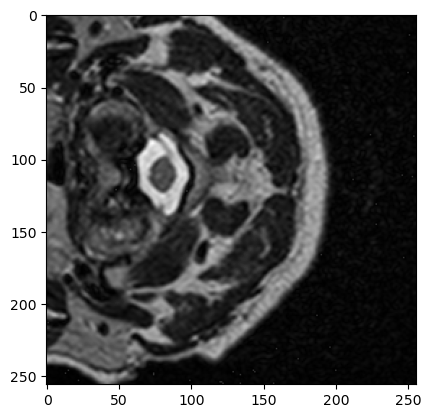

In [178]:
image_vis = np.squeeze(image, axis=0)
plt.imshow(image_vis[:, :, 10], cmap='gray')

In [71]:
image_with_batch = image_with_batch.to(device)


model.eval()
with torch.no_grad():  
    output = model(image_with_batch)
    output = output.cpu().numpy()
output_label_vis = np.squeeze(output, axis=0)
output_remove_one_hot = np.argmax(output_label_vis, axis=0)
print(np.unique(output_remove_one_hot))
positions = np.where(output_remove_one_hot == 2)
print(positions)

[0 2]
(array([ 1,  1,  1, 19, 20, 21]), array([45, 47, 49,  1,  7,  1]), array([ 7,  7,  7, 15, 15, 15]))


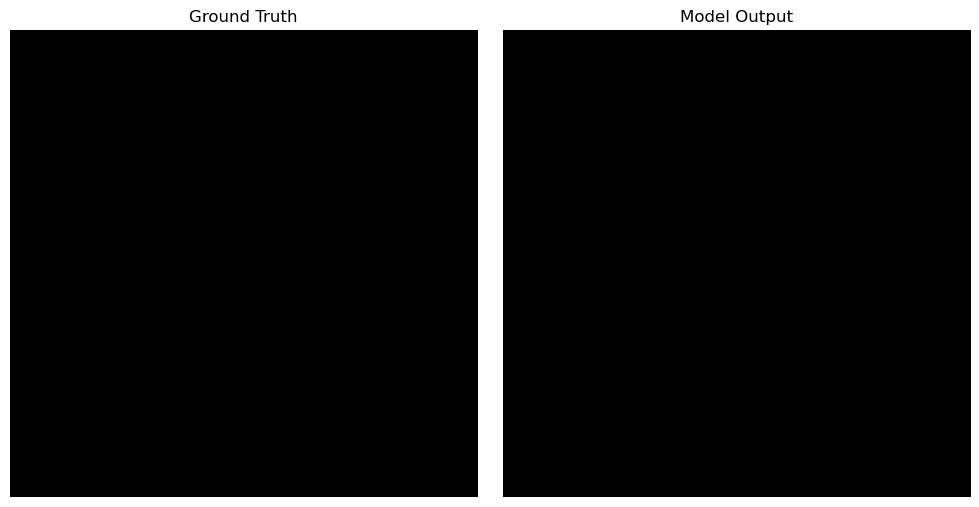

In [74]:
import matplotlib.pyplot as plt
layer=3


plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)  
plt.title("Ground Truth")
plt.imshow(label_remove_one_hot[:, :, layer], cmap='gray')
plt.axis('off') 

plt.subplot(2, 2, 2) 
plt.title("Model Output")
plt.imshow(output_remove_one_hot[:, :, layer], cmap='gray')
plt.axis('off') 

plt.tight_layout() 
plt.show()
